In [ ]:
!unrar x drive/MyDrive/sorted_data.rar

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
Extracting  sorted_data/train/scab/a10782c3de6f75b0.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a11a9ec3d805677e.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a12cde80caedc557.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a13f87e591dfa108.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a15a6aeb3ceb1521.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a16c934ba6cc9cec.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a16ec5864adea78c.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a186c6d87a212fcf.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a1874e8c18f95be3.jpg                   72%  OK 
Extracting  sorted_data/train/scab/a18af4fb4b83f890.jpg                   72%  OK 
Extracting  sor

In [ ]:
import tensorflow as tf

img_height, img_width = 224, 224
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "sorted_data/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "sorted_data/valid",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "sorted_data/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 16632 files belonging to 12 classes.
Found 1000 files belonging to 12 classes.
Found 1000 files belonging to 12 classes.
Slika: [[[154.89796  204.89796  142.35715 ]
  [161.95409  209.02551  154.73979 ]
  [176.04591  218.7551   175.38776 ]
  ...
  [ 94.68361  160.68361  113.11214 ]
  [ 98.051094 165.05109  113.90821 ]
  [106.984634 173.98463  119.984634]]

 [[149.4745   201.4745   136.76021 ]
  [157.78572  207.71939  148.7857  ]
  [164.33163  211.74489  162.61736 ]
  ...
  [ 94.50006  160.3011   114.785736]
  [ 93.26026  160.26027  109.05104 ]
  [101.59197  168.94914  113.87762 ]]

 [[144.56123  197.20409  131.41837 ]
  [147.72449  202.02551  139.27042 ]
  [154.54593  208.80612  150.5     ]
  ...
  [ 97.73469  163.49995  120.117325]
  [ 91.408195 158.4082   107.19387 ]
  [ 92.306114 160.30612  103.15304 ]]

 ...

 [[ 92.05612  167.05612   62.056126]
  [ 95.03059  170.0306    66.99998 ]
  [ 97.26022  171.42857   72.42862 ]
  ...
  [113.311    151.6682   123.647705]
  [109.34184  15

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.utils import class_weight
import numpy as np


img_height, img_width = 224, 224
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "sorted_data/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "sorted_data/valid",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "sorted_data/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

loaded_train_ds = train_ds
loaded_val_ds = val_ds
loaded_test_ds = test_ds



resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add your custom classification layer(s) for 12 classes
flatten = layers.Flatten()(resnet101.output)
output = layers.Dense(12, activation='softmax')(flatten)
model = Model(inputs=resnet101.input, outputs=output)

def learning_rate_schedule(epoch):
    if epoch < 1:
        return 0.0001
    elif epoch < 4:
      return 0.00005
    else:
        return 0.0000001

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Convert labels to one-hot encoding for training
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=12)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=12)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=12)))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True  # Restore the best model weights when stopping
)



class_labels = np.concatenate(list(loaded_train_ds.map(lambda x, y: y).as_numpy_iterator())).astype(np.int32)
class_counts = np.bincount(class_labels)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)

# Train the model
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[early_stopping, lr_scheduler],
                    class_weight=dict(enumerate(class_weights)))


Found 16632 files belonging to 12 classes.
Found 1000 files belonging to 12 classes.
Found 1000 files belonging to 12 classes.
171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/20
832/832 [==============================] - 235s 170ms/step - loss: 2.1979 - accuracy: 0.5214 - val_loss: 6.7878 - val_accuracy: 0.4980 - lr: 1.0000e-04
Epoch 2/20
832/832 [==============================] - 137s 165ms/step - loss: 0.5565 - accuracy: 0.8061 - val_loss: 0.7496 - val_accuracy: 0.7470 - lr: 5.0000e-05
Epoch 3/20
832/832 [==============================] - 141s 169ms/step - loss: 0.1564 - accuracy: 0.9369 - val_loss: 0.7312 - val_accuracy: 0.7980 - lr: 5.0000e-05
Epoch 4/20
832/832 [==============================] - 136s 164ms/step - loss: 0.0719 - accuracy: 0.9783 - val_loss: 0.6668 - val_accuracy: 0.8260 - lr: 5.0000e-05
Epoch 5/20
832/832 [==============================] - 137s 164ms/step - loss: 0.0572 - accuracy: 0.9856 - val_loss: 0.5769 - val_accuracy: 0.8310 - lr: 1.

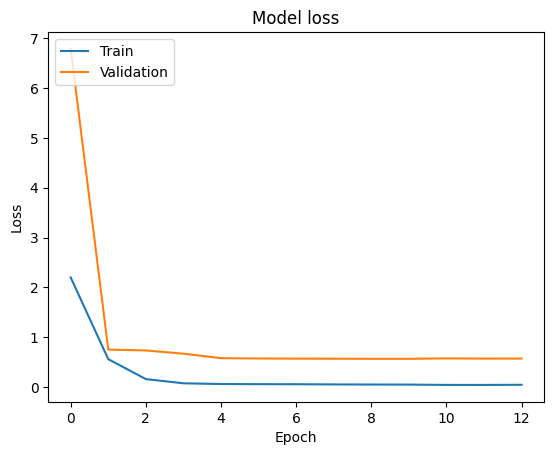

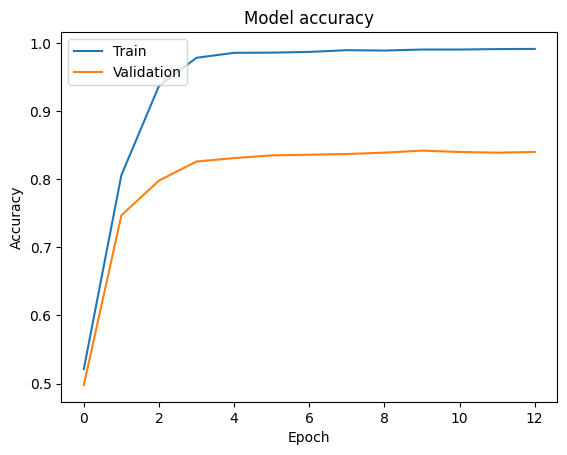

50/50 [==============================] - 4s 74ms/step - loss: 0.5580 - accuracy: 0.8520
[0.5579683780670166, 0.8519999980926514]
Test loss: 0.5579683780670166
Test accuracy: 0.8519999980926514


In [ ]:

import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_results = model.evaluate(test_ds)
print(test_results)
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])

50/50 [==============================] - 5s 93ms/step
Confusion Matrix:


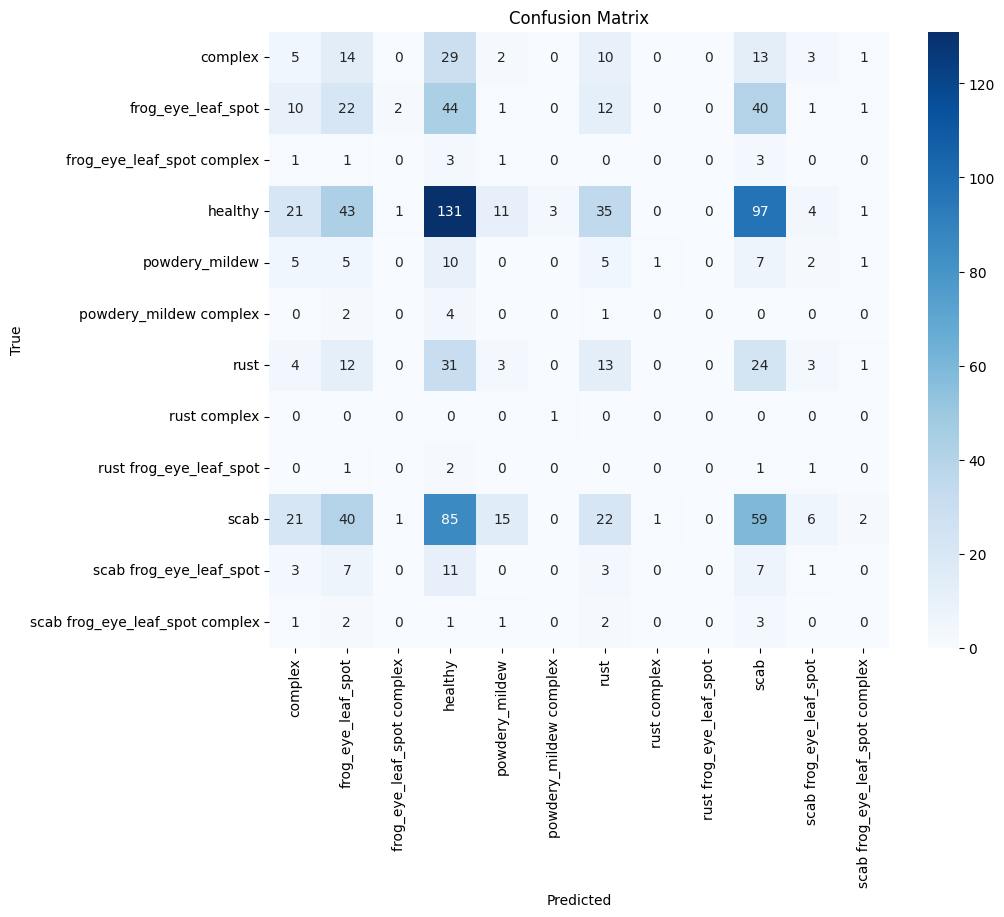

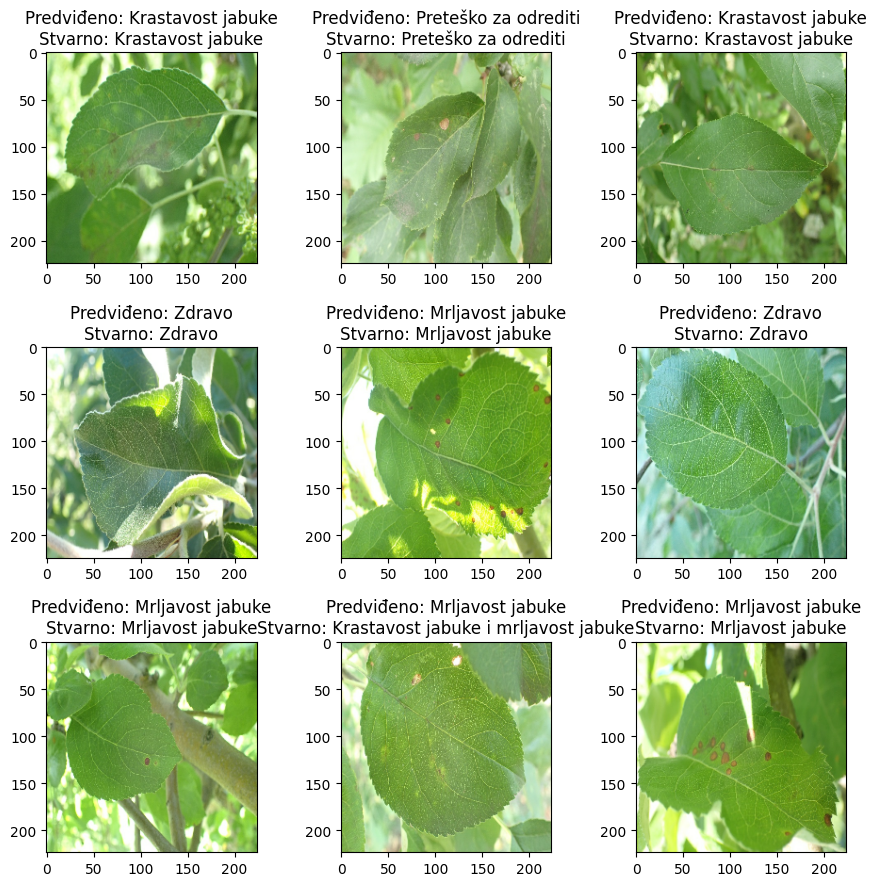

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

class_names = ["complex", "frog_eye_leaf_spot", "frog_eye_leaf_spot complex", "healthy", "powdery_mildew", "powdery_mildew complex", "rust", "rust complex", "rust frog_eye_leaf_spot", "scab", "scab frog_eye_leaf_spot", "scab frog_eye_leaf_spot complex"]


predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in loaded_test_ds], axis=0)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
#print(confusion_mat)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_names = ["Preteško za odrediti", "Mrljavost jabuke", "Teško je prepoznati, ali mrljavost jabuke je najvjerojatnija bolest", "Zdravo", "Pepelnica", "Teško je prepoznati, ali pepelnica je najvjerojatnija bolest", "Hrđa jabuke", "Teško je prepoznati, ali hrđa jabuke je najvjerojatnija bolest", "Hrđa jabuke i mrljavost jabuke", "Krastavost jabuke", "Krastavost jabuke i mrljavost jabuke", "Teško je prepoznati, ali krastavost jabuke i mrljavost jabuke su najvjerojatnije bolesti"]
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)  # Adjust margins and spacing
for images, labels in loaded_test_ds.take(1):
  classifications = model(images)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Predviđeno: " + class_names[index] + "\nStvarno: " + class_names[labels[i]])


In [ ]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

Output hidden; open in https://colab.research.google.com to view.